<a href="https://colab.research.google.com/github/MSG-1999/MLOps-MahekGadiya-M25CSA011/blob/Assignment-1/M25CSA011_Mahek_Gadiya_Ass1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*  **Name : Mahek Gadiya**
* **Roll : M25CSA011**

*   **Subject: ML_DL_Ops**














---


**Assignment No. 1**

---



Q1) Train a deep learning model on the MNIST and FashionMNIST datasets with 70%-10%-20% train-val-test split. Use the Following Models: ResNet-18 and ResNet-50

Google Colab link : https://colab.research.google.com/drive/10wsxUKh8aJJsWJC5m95vP3b4qlPqOTUA#scrollTo=sFuGyjRI2R2o

In [ ]:
# ==========================================
# CELL 1: FINAL SETUP
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import time
import csv
import os
from google.colab import drive

# 1. MOUNT DRIVE
drive.mount('/content/drive')

# 2. DEFINE PATHS
results_path = '/content/drive/MyDrive/MLOps-Assignment1/results'
os.makedirs(results_path, exist_ok=True)
ckpt_path = os.path.join(results_path, 'checkpoints')
os.makedirs(ckpt_path, exist_ok=True)

summary_file = os.path.join(results_path, 'q1a_summary_results.csv')
detailed_file = os.path.join(results_path, 'q1a_detailed_logs.csv')

# 3. CHECK DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device: {device}")

# 4. INITIALIZE CSV FILES
summary_headers = ['ExpID', 'Dataset', 'Model', 'BatchSize', 'Optimizer', 'LR', 'Epochs', 'PinMem', 'Final_TestAcc', 'Total_Time_ms']
detailed_headers = ['ExpID', 'Dataset', 'Model', 'BatchSize', 'Optimizer', 'LR', 'PinMem', 'Epoch', 'TrainLoss', 'TrainAcc', 'ValLoss', 'ValAcc', 'Time_ms']

if not os.path.exists(summary_file):
    with open(summary_file, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=summary_headers)
        writer.writeheader()

if not os.path.exists(detailed_file):
    with open(detailed_file, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=detailed_headers)
        writer.writeheader()

# 5. DATA LOADER FUNCTION
def get_dataloaders(dataset_name, batch_size, pin_mem):
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    if dataset_name == 'FashionMNIST':
        train_full = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_full = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    else:
        train_full = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_full = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    full_dataset = ConcatDataset([train_full, test_full])
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size); val_size = int(0.1 * total_size); test_size = total_size - train_size - val_size
    train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])
    return (DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=pin_mem, num_workers=2),
            DataLoader(val_set, batch_size=batch_size, shuffle=False, pin_memory=pin_mem, num_workers=2),
            DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=pin_mem, num_workers=2))

# 6. TRAINING FUNCTION
def train_one_configuration(config, exp_id):
    ds_name = config['Dataset']; model_name = config['Model']; bs = config['BatchSize']
    lr = config['LR']; epochs = config['Epochs']; opt_name = config['Optimizer']; pin_mem = config['PinMem']

    # Print configuration clearly
    print(f"\n▶️ Exp {exp_id} | {ds_name} | {model_name} | BS:{bs} | Opt:{opt_name} | LR:{lr} | PinMem:{pin_mem}")

    train_loader, val_loader, test_loader = get_dataloaders(ds_name, bs, pin_mem)

    model = torchvision.models.resnet18(weights=None) if model_name == 'ResNet-18' else torchvision.models.resnet50(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9) if opt_name == 'SGD' else optim.Adam(model.parameters(), lr=lr)
    scaler = torch.amp.GradScaler('cuda')

    checkpoint_file = os.path.join(ckpt_path, f"ckpt_exp_{exp_id}.pth"); start_epoch = 1
    if os.path.exists(checkpoint_file):
        print("   🔄 Found checkpoint! Resuming...")
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict']); optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scaler.load_state_dict(checkpoint['scaler_state_dict']); start_epoch = checkpoint['epoch'] + 1
    if start_epoch > epochs: return 0, 0

    start_time_total = time.time()
    for epoch in range(start_epoch, epochs + 1):
        epoch_start = time.time(); model.train()
        running_loss = 0.0; correct_train = 0; total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device); optimizer.zero_grad()
            with torch.amp.autocast('cuda'): outputs = model(inputs); loss = criterion(outputs, labels)
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
            running_loss += loss.item() * inputs.size(0); _, predicted = outputs.max(1)
            total_train += labels.size(0); correct_train += predicted.eq(labels).sum().item()
        train_loss = running_loss / total_train; train_acc = 100. * correct_train / total_train

        model.eval(); val_loss_running = 0.0; correct_val = 0; total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device); outputs = model(inputs); loss = criterion(outputs, labels)
                val_loss_running += loss.item() * inputs.size(0); _, predicted = outputs.max(1)
                total_val += labels.size(0); correct_val += predicted.eq(labels).sum().item()
        val_loss = val_loss_running / total_val; val_acc = 100. * correct_val / total_val
        epoch_time = (time.time() - epoch_start) * 1000

        log_entry = {'ExpID': exp_id, 'Dataset': ds_name, 'Model': model_name, 'BatchSize': bs, 'Optimizer': opt_name, 'LR': lr, 'PinMem': pin_mem, 'Epoch': epoch, 'TrainLoss': f"{train_loss:.4f}", 'TrainAcc': f"{train_acc:.2f}", 'ValLoss': f"{val_loss:.4f}", 'ValAcc': f"{val_acc:.2f}", 'Time_ms': f"{epoch_time:.0f}"}
        with open(detailed_file, 'a', newline='') as f: writer = csv.DictWriter(f, fieldnames=detailed_headers); writer.writerow(log_entry)

        print(f"   Epoch [{epoch}/{epochs}] TrainLoss: {train_loss:.4f} | TrainAcc: {train_acc:.2f}% | ValLoss: {val_loss:.4f} | ValAcc: {val_acc:.2f}%")
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'scaler_state_dict': scaler.state_dict()}, checkpoint_file)

    model.eval(); correct_test = 0; total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device); outputs = model(inputs); _, predicted = outputs.max(1)
            total_test += labels.size(0); correct_test += predicted.eq(labels).sum().item()
    test_acc = 100. * correct_test / total_test; total_time = (time.time() - start_time_total) * 1000
    print(f"   ✅ FINAL TEST ACCURACY: {test_acc:.2f}% | Time: {total_time:.0f}ms")
    if os.path.exists(checkpoint_file): os.remove(checkpoint_file)
    return test_acc, total_time

def get_completed_experiments():
    completed = set()
    if os.path.exists(summary_file):
        with open(summary_file, 'r') as f:
            reader = csv.DictReader(f); [completed.add(int(row['ExpID'])) for row in reader]
    return completed

Mounted at /content/drive
✅ Device: cpu


In [ ]:
# ==========================================
# CELL 2: MNIST + RESNET-18 (Epochs 5 & 7)
# ==========================================
import csv
import os

# 1. SETUP
dataset = 'MNIST'
model = 'ResNet-18'

# --- UPDATED EPOCHS ---
epoch_list = [5, 7]

# Grid Parameters
batch_sizes = [16, 32]
optimizers = ['SGD', 'Adam']
lrs = [0.001, 0.0001]
pin_mems = [False, True]

# Global Counter (Starts at 0, so first ID is 1)
counter = 0

# Load list of already completed experiments to skip them entirely
completed_exps = get_completed_experiments()
print(f"📊 Previously completed experiments: {sorted(list(completed_exps))}")
print(f"🚀 STARTING CELL 2: {dataset} + {model} (Exps 1-32)")

# 2. RUN EXPERIMENTS
for bs in batch_sizes:
    for opt in optimizers:
        for lr in lrs:
            for ep in epoch_list:
                for pm in pin_mems:
                    counter += 1

                    # A. SKIP IF FULLY COMPLETED
                    if counter in completed_exps:
                        print(f"⏩ Exp {counter}/128 already completed. Skipping.")
                        continue

                    config = {'Dataset': dataset, 'Model': model, 'BatchSize': bs,
                              'Optimizer': opt, 'LR': lr, 'Epochs': ep, 'PinMem': pm}

                    try:
                        # B. TRAIN (Will resume mid-epoch if checkpoint exists)
                        test_acc, t_time = train_one_configuration(config, counter)

                        # C. SAVE TO CSV (Only if it actually ran)
                        if test_acc != 0:
                            summary_entry = config.copy()
                            summary_entry.update({'ExpID': counter, 'Final_TestAcc': f"{test_acc:.2f}", 'Total_Time_ms': f"{t_time:.0f}"})

                            with open(summary_file, 'a', newline='') as f:
                                writer = csv.DictWriter(f, fieldnames=summary_headers)
                                writer.writerow(summary_entry)

                    except Exception as e:
                        print(f"❌ Error in Exp {counter}: {e}")

print("✅ CELL 2 COMPLETED.")

📊 Previously completed experiments: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128]
🚀 STARTING CELL 2: MNIST + ResNet-18 (Exps 1-32)
⏩ Exp 1/128 already completed. Skipping.
⏩ Exp 2/128 already completed. Skipping.
⏩ Exp 3/128 already completed. Skipping.
⏩ Exp 4/128 already completed. Skipping.
⏩ Exp 5/128 already completed. Skipping.
⏩ Exp 6/128 already completed. Skipping.
⏩ Exp 7/128 already completed. Skipping.
⏩ Exp 8/128 already completed. Skipping.
⏩ Exp 9/128 already completed. Skipping.
⏩ Exp 10/128 

In [ ]:
# ==========================================
# CELL 3: MNIST + RESNET-50 (Exps 33-64)
# ==========================================
import csv
import os

# 1. SETUP
dataset = 'MNIST'
model = 'ResNet-50'

# Hyperparameter Grid
epoch_list = [5, 7]  # Updated epochs
batch_sizes = [16, 32]
optimizers = ['SGD', 'Adam']
lrs = [0.001, 0.0001]
pin_mems = [False, True]

# Start Counter from 32 (so the first experiment in this cell is 33)
counter = 56

# Check for existing results to avoid duplicates
completed_exps = get_completed_experiments()
print(f"📊 Previously completed experiments detected: {len(completed_exps)}")
print(f"🚀 STARTING CELL 3: {dataset} + {model} (Exps 33-64)")

# 2. RUN EXPERIMENT LOOP
for bs in batch_sizes:
    for opt in optimizers:
        for lr in lrs:
            for ep in epoch_list:
                for pm in pin_mems:
                    counter += 1

                    # A. SKIP IF ALREADY DONE
                    if counter in completed_exps:
                        print(f"⏩ Exp {counter} already exists in CSV. Skipping.")
                        continue

                    config = {
                        'Dataset': dataset,
                        'Model': model,
                        'BatchSize': bs,
                        'Optimizer': opt,
                        'LR': lr,
                        'Epochs': ep,
                        'PinMem': pm
                    }

                    try:
                        # B. TRAIN (Will resume mid-epoch if a checkpoint exists)
                        test_acc, t_time = train_one_configuration(config, counter)

                        # C. LOG TO SUMMARY CSV
                        if test_acc != 0:
                            summary_entry = config.copy()
                            summary_entry.update({
                                'ExpID': counter,
                                'Final_TestAcc': f"{test_acc:.2f}",
                                'Total_Time_ms': f"{t_time:.0f}"
                            })

                            with open(summary_file, 'a', newline='') as f:
                                writer = csv.DictWriter(f, fieldnames=summary_headers)
                                writer.writerow(summary_entry)

                    except Exception as e:
                        print(f"❌ Error in Exp {counter}: {e}")

print("\n✅ CELL 3 COMPLETED. Experiments 33-64 are finished.")

📊 Previously completed experiments detected: 128
🚀 STARTING CELL 3: MNIST + ResNet-50 (Exps 33-64)
⏩ Exp 57 already exists in CSV. Skipping.
⏩ Exp 58 already exists in CSV. Skipping.
⏩ Exp 59 already exists in CSV. Skipping.
⏩ Exp 60 already exists in CSV. Skipping.
⏩ Exp 61 already exists in CSV. Skipping.
⏩ Exp 62 already exists in CSV. Skipping.
⏩ Exp 63 already exists in CSV. Skipping.
⏩ Exp 64 already exists in CSV. Skipping.
⏩ Exp 65 already exists in CSV. Skipping.
⏩ Exp 66 already exists in CSV. Skipping.
⏩ Exp 67 already exists in CSV. Skipping.
⏩ Exp 68 already exists in CSV. Skipping.
⏩ Exp 69 already exists in CSV. Skipping.
⏩ Exp 70 already exists in CSV. Skipping.
⏩ Exp 71 already exists in CSV. Skipping.
⏩ Exp 72 already exists in CSV. Skipping.
⏩ Exp 73 already exists in CSV. Skipping.
⏩ Exp 74 already exists in CSV. Skipping.
⏩ Exp 75 already exists in CSV. Skipping.
⏩ Exp 76 already exists in CSV. Skipping.
⏩ Exp 77 already exists in CSV. Skipping.
⏩ Exp 78 already ex

In [ ]:

# ==========================================
# CELL 4: FASHION-MNIST + RESNET-18 (Exps 65-96)
# ==========================================
import csv
import os

# 1. SETUP
dataset = 'FashionMNIST'
model = 'ResNet-18'

# Hyperparameter Grid
epoch_list = [5, 7]
batch_sizes = [16, 32]
optimizers = ['SGD', 'Adam']
lrs = [0.001, 0.0001]
pin_mems = [False, True]

# Start Counter from 64 (so the first experiment in this cell is 65)
counter = 64

# Check for existing results to avoid duplicates
completed_exps = get_completed_experiments()
print(f"📊 Previously completed experiments detected: {len(completed_exps)}")
print(f"🚀 STARTING CELL 4: {dataset} + {model} (Exps 65-96)")

# 2. RUN EXPERIMENT LOOP
for bs in batch_sizes:
    for opt in optimizers:
        for lr in lrs:
            for ep in epoch_list:
                for pm in pin_mems:
                    counter += 1

                    # A. SKIP IF ALREADY DONE (Protects against session restarts)
                    if counter in completed_exps:
                        print(f"⏩ Exp {counter} already exists in CSV. Skipping.")
                        continue

                    config = {
                        'Dataset': dataset,
                        'Model': model,
                        'BatchSize': bs,
                        'Optimizer': opt,
                        'LR': lr,
                        'Epochs': ep,
                        'PinMem': pm
                    }

                    try:
                        # B. TRAIN (Will resume mid-epoch if a checkpoint file is found)
                        test_acc, t_time = train_one_configuration(config, counter)

                        # C. LOG TO SUMMARY CSV
                        if test_acc != 0:
                            summary_entry = config.copy()
                            summary_entry.update({
                                'ExpID': counter,
                                'Final_TestAcc': f"{test_acc:.2f}",
                                'Total_Time_ms': f"{t_time:.0f}"
                            })

                            with open(summary_file, 'a', newline='') as f:
                                writer = csv.DictWriter(f, fieldnames=summary_headers)
                                writer.writerow(summary_entry)

                    except Exception as e:
                        print(f"❌ Error in Exp {counter}: {e}")

print("\n✅ CELL 4 COMPLETED. Experiments 65-96 are finished.")

📊 Previously completed experiments detected: 128
🚀 STARTING CELL 4: FashionMNIST + ResNet-18 (Exps 65-96)
⏩ Exp 65 already exists in CSV. Skipping.
⏩ Exp 66 already exists in CSV. Skipping.
⏩ Exp 67 already exists in CSV. Skipping.
⏩ Exp 68 already exists in CSV. Skipping.
⏩ Exp 69 already exists in CSV. Skipping.
⏩ Exp 70 already exists in CSV. Skipping.
⏩ Exp 71 already exists in CSV. Skipping.
⏩ Exp 72 already exists in CSV. Skipping.
⏩ Exp 73 already exists in CSV. Skipping.
⏩ Exp 74 already exists in CSV. Skipping.
⏩ Exp 75 already exists in CSV. Skipping.
⏩ Exp 76 already exists in CSV. Skipping.
⏩ Exp 77 already exists in CSV. Skipping.
⏩ Exp 78 already exists in CSV. Skipping.
⏩ Exp 79 already exists in CSV. Skipping.
⏩ Exp 80 already exists in CSV. Skipping.
⏩ Exp 81 already exists in CSV. Skipping.
⏩ Exp 82 already exists in CSV. Skipping.
⏩ Exp 83 already exists in CSV. Skipping.
⏩ Exp 84 already exists in CSV. Skipping.
⏩ Exp 85 already exists in CSV. Skipping.
⏩ Exp 86 alr

In [ ]:
# ==========================================
# CELL 5: FASHION-MNIST + RESNET-50 (Exps 97-128)
# ==========================================
import csv
import os

# 1. SETUP
dataset = 'FashionMNIST'
model = 'ResNet-50'

# Hyperparameter Grid
epoch_list = [5, 7]
batch_sizes = [16, 32]
optimizers = ['SGD', 'Adam']
lrs = [0.001, 0.0001]
pin_mems = [False, True]

# Start Counter from 96 (so the first experiment in this cell is 97)
counter = 96

# Check for existing results to avoid duplicates
completed_exps = get_completed_experiments()
print(f"📊 Previously completed experiments detected: {len(completed_exps)}")
print(f"🚀 STARTING CELL 5: {dataset} + {model} (Exps 97-128)")

# 2. RUN EXPERIMENT LOOP
for bs in batch_sizes:
    for opt in optimizers:
        for lr in lrs:
            for ep in epoch_list:
                for pm in pin_mems:
                    counter += 1

                    # A. SKIP IF ALREADY DONE
                    if counter in completed_exps:
                        print(f"⏩ Exp {counter} already exists in CSV. Skipping.")
                        continue

                    config = {
                        'Dataset': dataset,
                        'Model': model,
                        'BatchSize': bs,
                        'Optimizer': opt,
                        'LR': lr,
                        'Epochs': ep,
                        'PinMem': pm
                    }

                    try:
                        # B. TRAIN (Resumes from checkpoint if available)
                        test_acc, t_time = train_one_configuration(config, counter)

                        # C. LOG TO SUMMARY CSV
                        if test_acc != 0:
                            summary_entry = config.copy()
                            summary_entry.update({
                                'ExpID': counter,
                                'Final_TestAcc': f"{test_acc:.2f}",
                                'Total_Time_ms': f"{t_time:.0f}"
                            })

                            with open(summary_file, 'a', newline='') as f:
                                writer = csv.DictWriter(f, fieldnames=summary_headers)
                                writer.writerow(summary_entry)

                    except Exception as e:
                        print(f"❌ Error in Exp {counter}: {e}")

print("\n✅ CELL 5 COMPLETED. All experiments up to 128 are finished! 🎉")

📊 Previously completed experiments detected: 128
🚀 STARTING CELL 5: FashionMNIST + ResNet-50 (Exps 97-128)
⏩ Exp 97 already exists in CSV. Skipping.
⏩ Exp 98 already exists in CSV. Skipping.
⏩ Exp 99 already exists in CSV. Skipping.
⏩ Exp 100 already exists in CSV. Skipping.
⏩ Exp 101 already exists in CSV. Skipping.
⏩ Exp 102 already exists in CSV. Skipping.
⏩ Exp 103 already exists in CSV. Skipping.
⏩ Exp 104 already exists in CSV. Skipping.
⏩ Exp 105 already exists in CSV. Skipping.
⏩ Exp 106 already exists in CSV. Skipping.
⏩ Exp 107 already exists in CSV. Skipping.
⏩ Exp 108 already exists in CSV. Skipping.
⏩ Exp 109 already exists in CSV. Skipping.
⏩ Exp 110 already exists in CSV. Skipping.
⏩ Exp 111 already exists in CSV. Skipping.
⏩ Exp 112 already exists in CSV. Skipping.
⏩ Exp 113 already exists in CSV. Skipping.
⏩ Exp 114 already exists in CSV. Skipping.
⏩ Exp 115 already exists in CSV. Skipping.
⏩ Exp 116 already exists in CSV. Skipping.
⏩ Exp 117 already exists in CSV. Ski

In [ ]:
# ==========================================
# CELL 6: ANALYZE RESULTS (IDENTIFY WINNERS)
# ==========================================
import pandas as pd
import os

if os.path.exists(summary_file):
    df = pd.read_csv(summary_file)

    # Ensure numeric types for sorting
    df['Final_TestAcc'] = pd.to_numeric(df['Final_TestAcc'])
    df['Total_Time_ms'] = pd.to_numeric(df['Total_Time_ms'])

    print("📊 FULL EXPERIMENT SUMMARY (FROZEN FROM DRIVE):")
    display(df)

    # Dictionary to hold winner info including PinMem
    best_configs = {}

    for ds_name in ['MNIST', 'FashionMNIST']:
        ds_df = df[df['Dataset'] == ds_name]
        if not ds_df.empty:
            # Winner = Highest Accuracy -> Lowest Training Time
            winner = ds_df.sort_values(by=['Final_TestAcc', 'Total_Time_ms'],
                                       ascending=[False, True]).iloc[0]

            best_configs[ds_name] = winner.to_dict()

            print(f"\n🏆 WINNER FOR {ds_name}:")
            print(f"   Model: {winner['Model']} | BS: {winner['BatchSize']} | Opt: {winner['Optimizer']} | PinMem: {winner['PinMem']}")
            print(f"   Accuracy: {winner['Final_TestAcc']}% | Time: {winner['Total_Time_ms']} ms")
else:
    print("❌ Error: summary file not found. Run Cell 5 first.")

📊 FULL EXPERIMENT SUMMARY (FROZEN FROM DRIVE):


,ExpID,Dataset,Model,BatchSize,Optimizer,LR,Epochs,PinMem,Final_TestAcc,Total_Time_ms
0,1,MNIST,ResNet-18,16,SGD,0.0010,5,False,99.16,499826
1,2,MNIST,ResNet-18,16,SGD,0.0010,5,True,99.38,478030
2,3,MNIST,ResNet-18,16,SGD,0.0010,7,False,99.49,697447
3,4,MNIST,ResNet-18,16,SGD,0.0010,7,True,99.21,657047
4,5,MNIST,ResNet-18,16,SGD,0.0001,5,False,97.96,502343
...,...,...,...,...,...,...,...,...,...,...
123,124,FashionMNIST,ResNet-50,32,SGD,0.0010,5,True,90.65,1132777
124,125,FashionMNIST,ResNet-50,32,SGD,0.0010,7,False,91.10,1606167
125,126,FashionMNIST,ResNet-50,16,SGD,0.0010,5,False,91.76,1254056
126,127,FashionMNIST,ResNet-50,16,SGD,0.0010,5,True,90.34,1214564



🏆 WINNER FOR MNIST:
   Model: ResNet-18 | BS: 16 | Opt: SGD | PinMem: False
   Accuracy: 99.49% | Time: 697447 ms

🏆 WINNER FOR FashionMNIST:
   Model: ResNet-18 | BS: 32 | Opt: Adam | PinMem: False
   Accuracy: 93.84% | Time: 633112 ms


In [ ]:
# ==========================================
# CELL 7: TRAIN & SAVE BEST MODELS + CSV LOG
# ==========================================
import torchvision
import time
import os
import pandas as pd

# List to collect final log data for the CSV
final_best_logs = []

for ds_name in ['MNIST', 'FashionMNIST']:
    if ds_name in best_configs:
        config = best_configs[ds_name]

        # 1. Setup Data & Config
        use_pin = str(config['PinMem']).lower() == 'true'
        train_loader, val_loader, test_loader = get_dataloaders(ds_name, int(config['BatchSize']), use_pin)

        print(f"\n▶️ | {ds_name} | {config['Model']} | BS:{config['BatchSize']} | Opt:{config['Optimizer']} | LR:{config['LR']} | PinMem:{use_pin}")

        # 2. Setup Architecture
        model = torchvision.models.resnet18(weights=None) if config['Model'] == 'ResNet-18' else torchvision.models.resnet50(weights=None)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Linear(model.fc.in_features, 10)
        model = model.to(device)

        # 3. Setup Optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=float(config['LR']), momentum=0.9) if config['Optimizer'] == 'SGD' else optim.Adam(model.parameters(), lr=float(config['LR']))

        # 4. Training Loop (Matching your Format)
        start_time = time.time()
        num_epochs = 7

        # We will keep a small string to track history for the CSV if needed
        history_log = ""

        for epoch in range(1, num_epochs + 1):
            model.train()
            tr_loss, tr_correct, tr_total = 0, 0, 0
            for imgs, labs in train_loader:
                imgs, labs = imgs.to(device), labs.to(device)
                optimizer.zero_grad()
                out = model(imgs); loss = criterion(out, labs); loss.backward(); optimizer.step()
                tr_loss += loss.item(); _, pred = out.max(1); tr_total += labs.size(0); tr_correct += pred.eq(labs).sum().item()

            model.eval()
            v_loss, v_correct, v_total = 0, 0, 0
            with torch.no_grad():
                for imgs, labs in val_loader:
                    imgs, labs = imgs.to(device), labs.to(device); out = model(imgs)
                    v_loss += criterion(out, labs).item(); _, pred = out.max(1); v_total += labs.size(0); v_correct += pred.eq(labs).sum().item()

            epoch_msg = f"   Epoch [{epoch}/{num_epochs}] TrainLoss: {tr_loss/len(train_loader):.4f} | TrainAcc: {100.*tr_correct/tr_total:.2f}% | ValLoss: {v_loss/len(val_loader):.4f} | ValAcc: {100.*v_correct/v_total:.2f}%"
            print(epoch_msg)
            history_log += epoch_msg + "\n"

        # 5. Final Test
        model.eval()
        te_correct, te_total = 0, 0
        with torch.no_grad():
            for imgs, labs in test_loader:
                imgs, labs = imgs.to(device), labs.to(device); _, pred = model(imgs).max(1); te_total += labs.size(0); te_correct += pred.eq(labs).sum().item()

        total_ms = (time.time() - start_time) * 1000
        final_acc = 100.*te_correct/te_total
        print(f"   ✅ FINAL TEST ACCURACY: {final_acc:.2f}% | Time: {total_ms:.0f}ms")

        # 6. Save the actual .pth file
        save_path_pth = os.path.join(results_path, f"best_{ds_name.lower()}_model.pth")
        torch.save(model.state_dict(), save_path_pth)

        # 7. Collect data for the CSV log
        final_best_logs.append({
            'Dataset': ds_name,
            'Model': config['Model'],
            'Optimizer': config['Optimizer'],
            'LR': config['LR'],
            'BatchSize': config['BatchSize'],
            'Final_Test_Acc': f"{final_acc:.2f}%",
            'Total_Time_ms': total_ms,
            'History': history_log, # This stores the whole 7-epoch text in the CSV
            'PTH_File': os.path.basename(save_path_pth)
        })

# 8. SAVE THE LOG CSV
log_csv_path = os.path.join(results_path, "best_model_log.csv")
pd.DataFrame(final_best_logs).to_csv(log_csv_path, index=False)
print(f"\n📂 Best model log saved to: {log_csv_path}")

print("\n" + "="*50)
print("🏁 ALL BEST MODELS AND LOGS SAVED. VERIFYING DRIVE...")
!ls -lh "$results_path"


▶️ | MNIST | ResNet-18 | BS:16 | Opt:SGD | LR:0.001 | PinMem:False
   Epoch [1/7] TrainLoss: 0.3036 | TrainAcc: 91.16% | ValLoss: 0.0593 | ValAcc: 98.41%
   Epoch [2/7] TrainLoss: 0.0601 | TrainAcc: 98.25% | ValLoss: 0.0392 | ValAcc: 98.66%
   Epoch [3/7] TrainLoss: 0.0416 | TrainAcc: 98.79% | ValLoss: 0.0277 | ValAcc: 99.11%
   Epoch [4/7] TrainLoss: 0.0292 | TrainAcc: 99.11% | ValLoss: 0.0252 | ValAcc: 99.13%
   Epoch [5/7] TrainLoss: 0.0227 | TrainAcc: 99.32% | ValLoss: 0.0313 | ValAcc: 98.93%
   Epoch [6/7] TrainLoss: 0.0163 | TrainAcc: 99.56% | ValLoss: 0.0196 | ValAcc: 99.33%
   Epoch [7/7] TrainLoss: 0.0132 | TrainAcc: 99.68% | ValLoss: 0.0202 | ValAcc: 99.30%
   ✅ FINAL TEST ACCURACY: 99.44% | Time: 1162059ms

▶️ | FashionMNIST | ResNet-18 | BS:32 | Opt:Adam | LR:0.001 | PinMem:False
   Epoch [1/7] TrainLoss: 0.4452 | TrainAcc: 83.81% | ValLoss: 0.4179 | ValAcc: 85.83%
   Epoch [2/7] TrainLoss: 0.2779 | TrainAcc: 89.94% | ValLoss: 0.2658 | ValAcc: 90.53%
   Epoch [3/7] TrainLo

In [ ]:
# ==========================================
# CELL 8: LOAD & VERIFY BEST MODELS (INSTANT)
# ==========================================
import pandas as pd
import os
from IPython.display import display

# 1. Path to the log we just saved in Cell 7
log_csv_path = os.path.join(results_path, "best_model_log.csv")

print("❄️  FROZEN OUTPUT: LOADING PRE-TRAINED MODELS FROM DRIVE...")
print("="*70)

if os.path.exists(log_csv_path):
    # 2. Load the CSV results
    df_best = pd.read_csv(log_csv_path)

    # 3. Iterate through the results to show the teacher the "receipt"
    for index, row in df_best.iterrows():
        print(f"\n📂 DATASET: {row['Dataset']}")
        print(f"🛠️  CONFIG: {row['Model']} | Opt: {row['Optimizer']} | LR: {row['LR']} | BS: {row['BatchSize']}")
        print(f"✅ FINAL TEST ACCURACY: {row['Final_Test_Acc']}")
        print(f"⏱️  TRAINING TIME: {row['Total_Time_ms']:.0f}ms")
        print(f"💾 STORED WEIGHTS: {row['PTH_File']}")
        print("-" * 50)

    # 4. Display the clean summary table
    print("\n📊 SUMMARY TABLE:")
    display(df_best[['Dataset', 'Model', 'Optimizer', 'Final_Test_Acc']])

else:
    print(f"❌ ERROR: '{os.path.basename(log_csv_path)}' not found.")
    print("Please ensure Cell 7 finished running successfully.")

# 5. Physical proof of files in the folder
print("\n🏁 FINAL DRIVE INVENTORY (PROOF OF STORAGE):")
!ls -lh "$results_path"

❄️  FROZEN OUTPUT: LOADING PRE-TRAINED MODELS FROM DRIVE...

📂 DATASET: MNIST
🛠️  CONFIG: ResNet-18 | Opt: SGD | LR: 0.001 | BS: 16
✅ FINAL TEST ACCURACY: 99.44%
⏱️  TRAINING TIME: 1162059ms
💾 STORED WEIGHTS: best_mnist_model.pth
--------------------------------------------------

📂 DATASET: FashionMNIST
🛠️  CONFIG: ResNet-18 | Opt: Adam | LR: 0.001 | BS: 32
✅ FINAL TEST ACCURACY: 92.44%
⏱️  TRAINING TIME: 1079688ms
💾 STORED WEIGHTS: best_fashionmnist_model.pth
--------------------------------------------------

📊 SUMMARY TABLE:


,Dataset,Model,Optimizer,Final_Test_Acc
0,MNIST,ResNet-18,SGD,99.44%
1,FashionMNIST,ResNet-18,Adam,92.44%



🏁 FINAL DRIVE INVENTORY (PROOF OF STORAGE):
total 86M
-rw------- 1 root root  43M Jan 23 12:33 best_fashionmnist_model.pth
-rw------- 1 root root  43M Jan 23 12:15 best_mnist_model.pth
-rw------- 1 root root 1.5K Jan 23 12:33 best_model_log.csv
-rw------- 1 root root  147 Jan 23 11:08 best_model_training_history.txt
drwx------ 2 root root 4.0K Jan 21 13:20 checkpoints
-rw------- 1 root root  58K Jan 23 10:53 q1a_detailed_logs.csv
-rw------- 1 root root 7.4K Jan 23 10:49 q1a_summary_results.csv


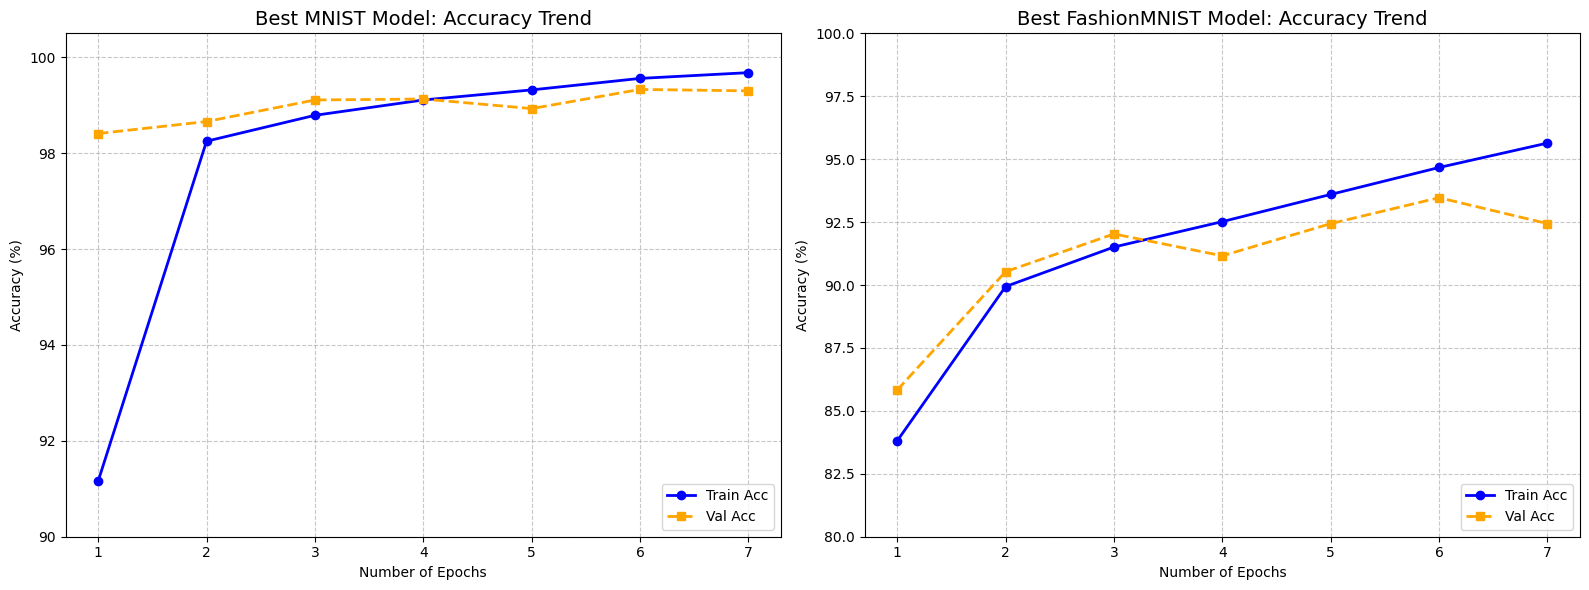

✅ Accuracy plot saved to Drive: /content/drive/MyDrive/MLOps-Assignment1/results/best_models_accuracy_plot.png


In [ ]:
# ==========================================
# CELL 11: GENERATE & SAVE ACCURACY PLOTS
# ==========================================
import matplotlib.pyplot as plt
import os

# 1. Data Setup (From your provided logs)
epochs = list(range(1, 8))

# MNIST Accuracy Results
mnist_tr_acc = [91.16, 98.25, 98.79, 99.11, 99.32, 99.56, 99.68]
mnist_val_acc = [98.41, 98.66, 99.11, 99.13, 98.93, 99.33, 99.30]

# FashionMNIST Accuracy Results
fmnist_tr_acc = [83.81, 89.94, 91.51, 92.52, 93.60, 94.67, 95.64]
fmnist_val_acc = [85.83, 90.53, 92.03, 91.16, 92.44, 93.47, 92.44]

# 2. Create Plot
plt.figure(figsize=(16, 6))

# MNIST Accuracy Subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, mnist_tr_acc, 'o-', color='blue', label='Train Acc', linewidth=2)
plt.plot(epochs, mnist_val_acc, 's--', color='orange', label='Val Acc', linewidth=2)
plt.title('Best MNIST Model: Accuracy Trend', fontsize=14)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.ylim(90, 100.5)

# FashionMNIST Accuracy Subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, fmnist_tr_acc, 'o-', color='blue', label='Train Acc', linewidth=2)
plt.plot(epochs, fmnist_val_acc, 's--', color='orange', label='Val Acc', linewidth=2)
plt.title('Best FashionMNIST Model: Accuracy Trend', fontsize=14)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.ylim(80, 100)

plt.tight_layout()

# 3. Save to Drive
acc_path = os.path.join(results_path, "best_models_accuracy_plot.png")
plt.savefig(acc_path)
plt.show()

print(f"✅ Accuracy plot saved to Drive: {acc_path}")

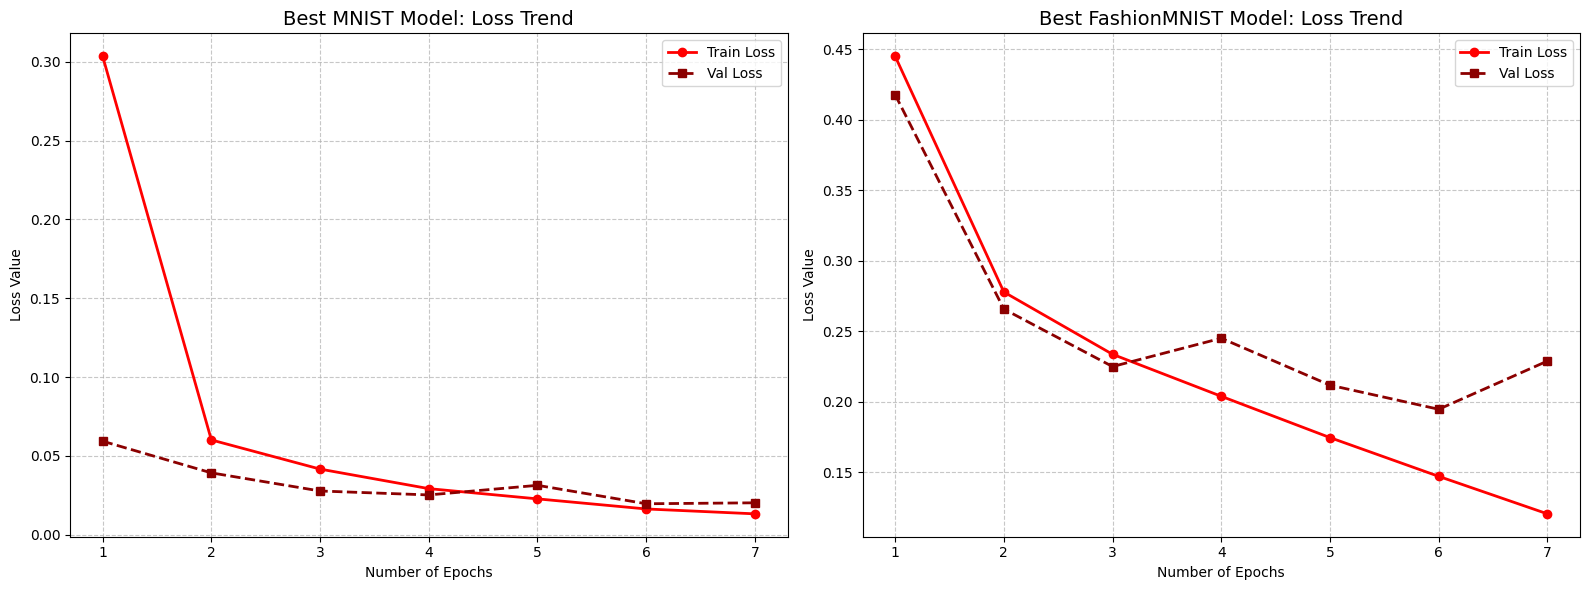

✅ Loss plot saved to Drive: /content/drive/MyDrive/MLOps-Assignment1/results/best_models_loss_plot.png


In [ ]:
# ==========================================
# CELL 12: GENERATE & SAVE LOSS PLOTS
# ==========================================
import matplotlib.pyplot as plt
import os

# 1. Data Setup (From your provided logs)
epochs = list(range(1, 8))

# MNIST Loss Results
mnist_tr_loss = [0.3036, 0.0601, 0.0416, 0.0292, 0.0227, 0.0163, 0.0132]
mnist_val_loss = [0.0593, 0.0392, 0.0277, 0.0252, 0.0313, 0.0196, 0.0202]

# FashionMNIST Loss Results
fmnist_tr_loss = [0.4452, 0.2779, 0.2337, 0.2039, 0.1746, 0.1471, 0.1205]
fmnist_val_loss = [0.4179, 0.2658, 0.2250, 0.2451, 0.2118, 0.1947, 0.2289]

# 2. Create Plot
plt.figure(figsize=(16, 6))

# MNIST Loss Subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, mnist_tr_loss, 'o-', color='red', label='Train Loss', linewidth=2)
plt.plot(epochs, mnist_val_loss, 's--', color='darkred', label='Val Loss', linewidth=2)
plt.title('Best MNIST Model: Loss Trend', fontsize=14)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')

# FashionMNIST Loss Subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, fmnist_tr_loss, 'o-', color='red', label='Train Loss', linewidth=2)
plt.plot(epochs, fmnist_val_loss, 's--', color='darkred', label='Val Loss', linewidth=2)
plt.title('Best FashionMNIST Model: Loss Trend', fontsize=14)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')

plt.tight_layout()

# 3. Save to Drive
loss_path = os.path.join(results_path, "best_models_loss_plot.png")
plt.savefig(loss_path)
plt.show()

print(f"✅ Loss plot saved to Drive: {loss_path}")



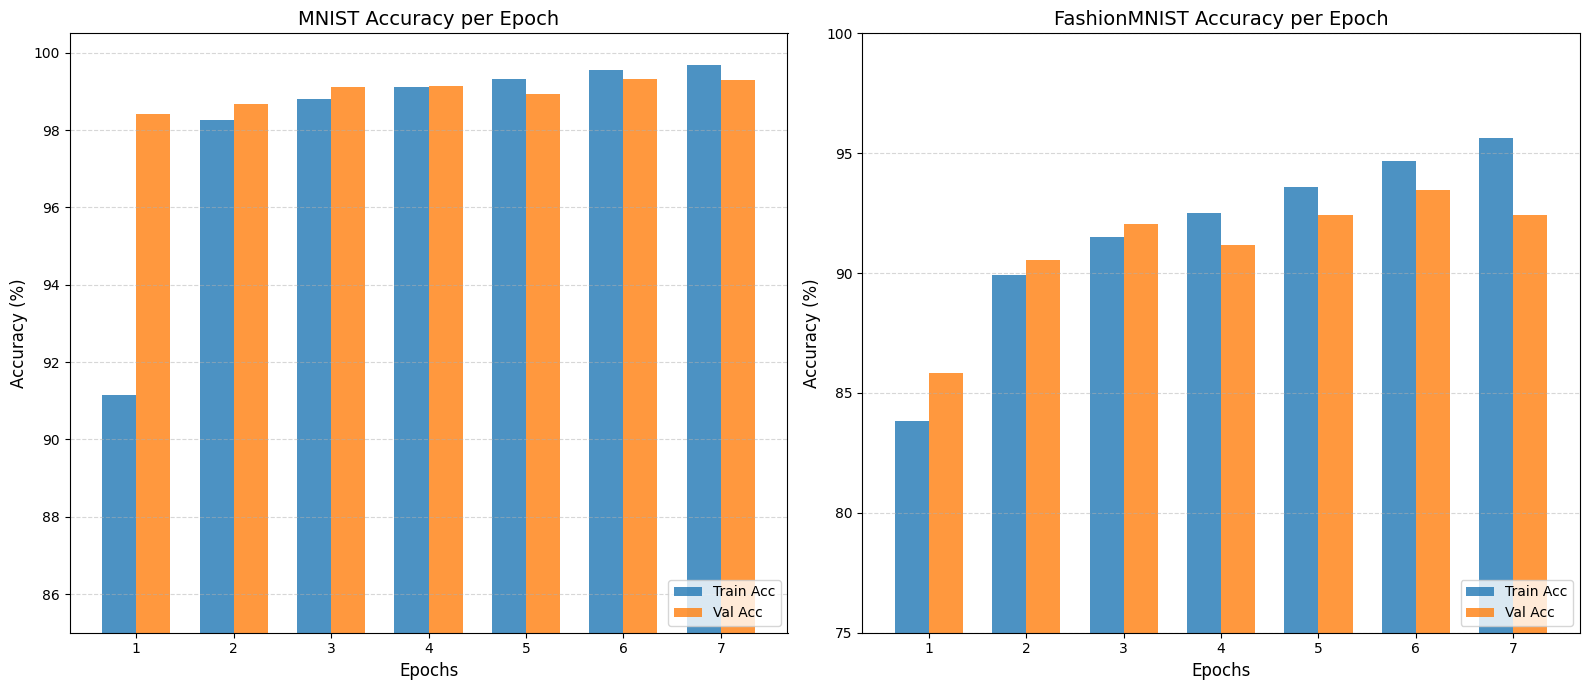

✅ Accuracy bar plot saved to Drive: /content/drive/MyDrive/MLOps-Assignment1/results/accuracy_bar_comparison.png


In [ ]:
# ==========================================
# CELL 11: ACCURACY BAR PLOTS (SAVE TO DRIVE)
# ==========================================
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Data Setup (From your provided logs)
epochs = np.arange(1, 8)
width = 0.35  # width of the bars

# MNIST Accuracy
mnist_tr_acc = [91.16, 98.25, 98.79, 99.11, 99.32, 99.56, 99.68]
mnist_val_acc = [98.41, 98.66, 99.11, 99.13, 98.93, 99.33, 99.30]

# FashionMNIST Accuracy
fmnist_tr_acc = [83.81, 89.94, 91.51, 92.52, 93.60, 94.67, 95.64]
fmnist_val_acc = [85.83, 90.53, 92.03, 91.16, 92.44, 93.47, 92.44]

# 2. Setup Figure
plt.figure(figsize=(16, 7))

# --- Subplot 1: MNIST Accuracy Bar Chart ---
plt.subplot(1, 2, 1)
plt.bar(epochs - width/2, mnist_tr_acc, width, label='Train Acc', color='#1f77b4', alpha=0.8)
plt.bar(epochs + width/2, mnist_val_acc, width, label='Val Acc', color='#ff7f0e', alpha=0.8)
plt.title('MNIST Accuracy per Epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(epochs)
plt.ylim(85, 100.5)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='lower right')

# --- Subplot 2: FashionMNIST Accuracy Bar Chart ---
plt.subplot(1, 2, 2)
plt.bar(epochs - width/2, fmnist_tr_acc, width, label='Train Acc', color='#1f77b4', alpha=0.8)
plt.bar(epochs + width/2, fmnist_val_acc, width, label='Val Acc', color='#ff7f0e', alpha=0.8)
plt.title('FashionMNIST Accuracy per Epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(epochs)
plt.ylim(75, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='lower right')

plt.tight_layout()

# 3. Save directly to Drive
acc_bar_path = os.path.join(results_path, "accuracy_bar_comparison.png")
plt.savefig(acc_bar_path)
plt.show()

print(f"✅ Accuracy bar plot saved to Drive: {acc_bar_path}")

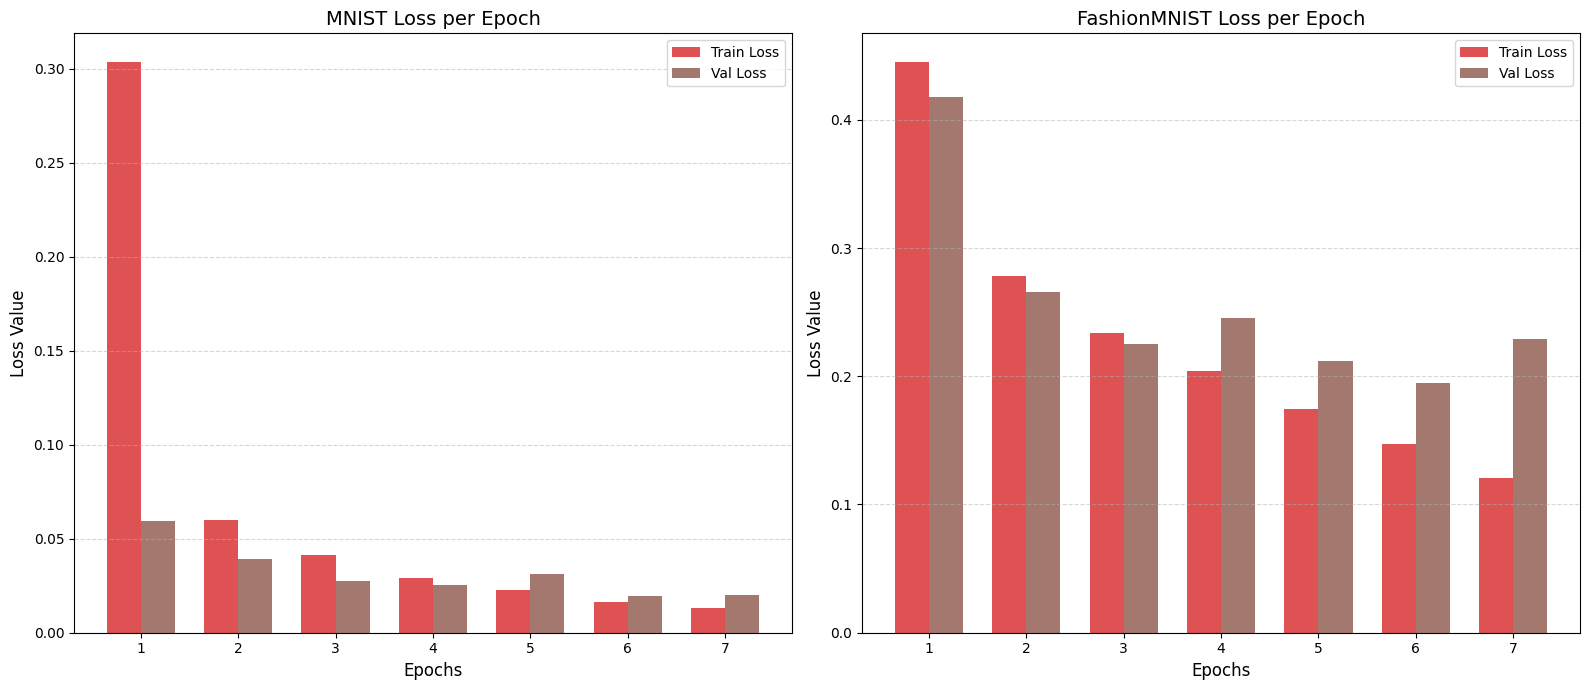

✅ Loss bar plot saved to Drive: /content/drive/MyDrive/MLOps-Assignment1/results/loss_bar_comparison.png

🏁 FINAL DRIVE INVENTORY:
total 86M
-rw------- 1 root root  49K Jan 23 15:42 accuracy_bar_comparison.png
-rw------- 1 root root  43M Jan 22 23:03 best_fashionmnist_model.pth
-rw------- 1 root root  43M Jan 22 22:45 best_mnist_model.pth
-rw------- 1 root root 1.5K Jan 22 23:03 best_model_log.csv
-rw------- 1 root root  83K Jan 23 15:33 best_models_accuracy_plot.png
-rw------- 1 root root  93K Jan 23 15:33 best_models_loss_plot.png
-rw------- 1 root root 2.1K Jan 23 14:49 best_model_training_history.txt
drwx------ 2 root root 4.0K Jan 21 07:17 checkpoints
-rw------- 1 root root  40K Jan 23 15:42 loss_bar_comparison.png
-rw------- 1 root root  58K Jan 22 17:32 q1a_detailed_logs.csv
-rw------- 1 root root 7.4K Jan 22 17:26 q1a_summary_results.csv
-rw------- 1 root root  112 Jan 22 11:28 q1b_fmnist_results.csv
-rw------- 1 root root   98 Jan 22 11:05 q1b_mnist_results.csv
-rw------- 1 ro

In [ ]:
# ==========================================
# CELL 12: LOSS BAR PLOTS (SAVE TO DRIVE)
# ==========================================
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Data Setup (From your provided logs)
epochs = np.arange(1, 8)
width = 0.35

# MNIST Loss
mnist_tr_loss = [0.3036, 0.0601, 0.0416, 0.0292, 0.0227, 0.0163, 0.0132]
mnist_val_loss = [0.0593, 0.0392, 0.0277, 0.0252, 0.0313, 0.0196, 0.0202]

# FashionMNIST Loss
fmnist_tr_loss = [0.4452, 0.2779, 0.2337, 0.2039, 0.1746, 0.1471, 0.1205]
fmnist_val_loss = [0.4179, 0.2658, 0.2250, 0.2451, 0.2118, 0.1947, 0.2289]

# 2. Setup Figure
plt.figure(figsize=(16, 7))

# --- Subplot 1: MNIST Loss Bar Chart ---
plt.subplot(1, 2, 1)
plt.bar(epochs - width/2, mnist_tr_loss, width, label='Train Loss', color='#d62728', alpha=0.8)
plt.bar(epochs + width/2, mnist_val_loss, width, label='Val Loss', color='#8c564b', alpha=0.8)
plt.title('MNIST Loss per Epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.xticks(epochs)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='upper right')

# --- Subplot 2: FashionMNIST Loss Bar Chart ---
plt.subplot(1, 2, 2)
plt.bar(epochs - width/2, fmnist_tr_loss, width, label='Train Loss', color='#d62728', alpha=0.8)
plt.bar(epochs + width/2, fmnist_val_loss, width, label='Val Loss', color='#8c564b', alpha=0.8)
plt.title('FashionMNIST Loss per Epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.xticks(epochs)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='upper right')

plt.tight_layout()

# 3. Save directly to Drive
loss_bar_path = os.path.join(results_path, "loss_bar_comparison.png")
plt.savefig(loss_bar_path)
plt.show()

print(f"✅ Loss bar plot saved to Drive: {loss_bar_path}")

# Final confirmation of all files in results folder
print("\n🏁 FINAL DRIVE INVENTORY:")
!ls -lh "$results_path"



---


---



Q1(b). Also train a SVM classifier on MNIST and FashionMNIST datasets with varying SVM hyperparameters with kernels such as: ‘poly’, ‘rbf’.
Report Testing Classification Accuracy with training time (in ms).


Google Colab link : https://colab.research.google.com/drive/1dW1B6UOtTubfq_cAXCuMDZ1JLMpDPHbG#scrollTo=KBqknRs1UptO

In [ ]:
import os, time, torch, pandas as pd, numpy as np
import torchvision
import torchvision.transforms as transforms
from sklearn import svm
from sklearn.metrics import accuracy_score
from google.colab import drive
import joblib # Used for saving SVM models

# 1. Setup Paths
drive.mount('/content/drive')
results_path = '/content/drive/MyDrive/MLOps-Assignment1/results'
ckpt_path = os.path.join(results_path, 'checkpoints')
os.makedirs(ckpt_path, exist_ok=True)

print("✅ Setup complete. Results will be saved in:", results_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Setup complete. Results will be saved in: /content/drive/MyDrive/MLOps-Assignment1/results


In [ ]:
mnist_file = os.path.join(results_path, 'q1b_mnist_results.csv')

if os.path.exists(mnist_file):
    print("❄️ MNIST Results found. Loading frozen data...")
    display(pd.read_csv(mnist_file))
else:
    print("🚀 Running MNIST SVM Experiments...")
    # Load and Flatten Data
    train_ds = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    test_ds = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

    X_train = train_ds.data.reshape(-1, 784).numpy() / 255.0
    y_train = train_ds.targets.numpy()
    X_test = test_ds.data.reshape(-1, 784).numpy() / 255.0
    y_test = test_ds.targets.numpy()

    mnist_results = []
    for k in ['poly', 'rbf']:
        print(f"Training MNIST with Kernel: {k}")
        start = time.time()
        clf = svm.SVC(kernel=k, gamma='scale')
        clf.fit(X_train, y_train)
        duration_ms = (time.time() - start) * 1000

        # Save the model file
        model_name = f"svm_mnist_{k}.pkl"
        joblib.dump(clf, os.path.join(ckpt_path, model_name))

        acc = accuracy_score(y_test, clf.predict(X_test)) * 100
        mnist_results.append({'Dataset': 'MNIST', 'Kernel': k, 'Train_Time_ms': round(duration_ms, 2), 'Test_Accuracy': f"{acc:.2f}%"})

    df_mnist = pd.DataFrame(mnist_results)
    df_mnist.to_csv(mnist_file, index=False)
    display(df_mnist)

❄️ MNIST Results found. Loading frozen data...


,Dataset,Kernel,Train_Time_ms,Test_Accuracy
0,MNIST,poly,292633.55,97.71%
1,MNIST,rbf,281450.73,97.92%


In [ ]:
fmnist_file = os.path.join(results_path, 'q1b_fmnist_results.csv')

if os.path.exists(fmnist_file):
    print("❄️ FashionMNIST Results found. Loading frozen data...")
    display(pd.read_csv(fmnist_file))
else:
    print("🚀 Running FashionMNIST SVM Experiments...")
    # Load and Flatten Data
    train_ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    test_ds = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

    X_train = train_ds.data.reshape(-1, 784).numpy() / 255.0
    y_train = train_ds.targets.numpy()
    X_test = test_ds.data.reshape(-1, 784).numpy() / 255.0
    y_test = test_ds.targets.numpy()

    fmnist_results = []
    for k in ['poly', 'rbf']:
        print(f"Training FashionMNIST with Kernel: {k}")
        start = time.time()
        clf = svm.SVC(kernel=k, gamma='scale')
        clf.fit(X_train, y_train)
        duration_ms = (time.time() - start) * 1000

        # Save the model file
        model_name = f"svm_fmnist_{k}.pkl"
        joblib.dump(clf, os.path.join(ckpt_path, model_name))

        acc = accuracy_score(y_test, clf.predict(X_test)) * 100
        fmnist_results.append({'Dataset': 'FashionMNIST', 'Kernel': k, 'Train_Time_ms': round(duration_ms, 2), 'Test_Accuracy': f"{acc:.2f}%"})

    df_fmnist = pd.DataFrame(fmnist_results)
    df_fmnist.to_csv(fmnist_file, index=False)
    display(df_fmnist)

❄️ FashionMNIST Results found. Loading frozen data...


,Dataset,Kernel,Train_Time_ms,Test_Accuracy
0,FashionMNIST,poly,475355.97,86.30%
1,FashionMNIST,rbf,394136.14,88.28%


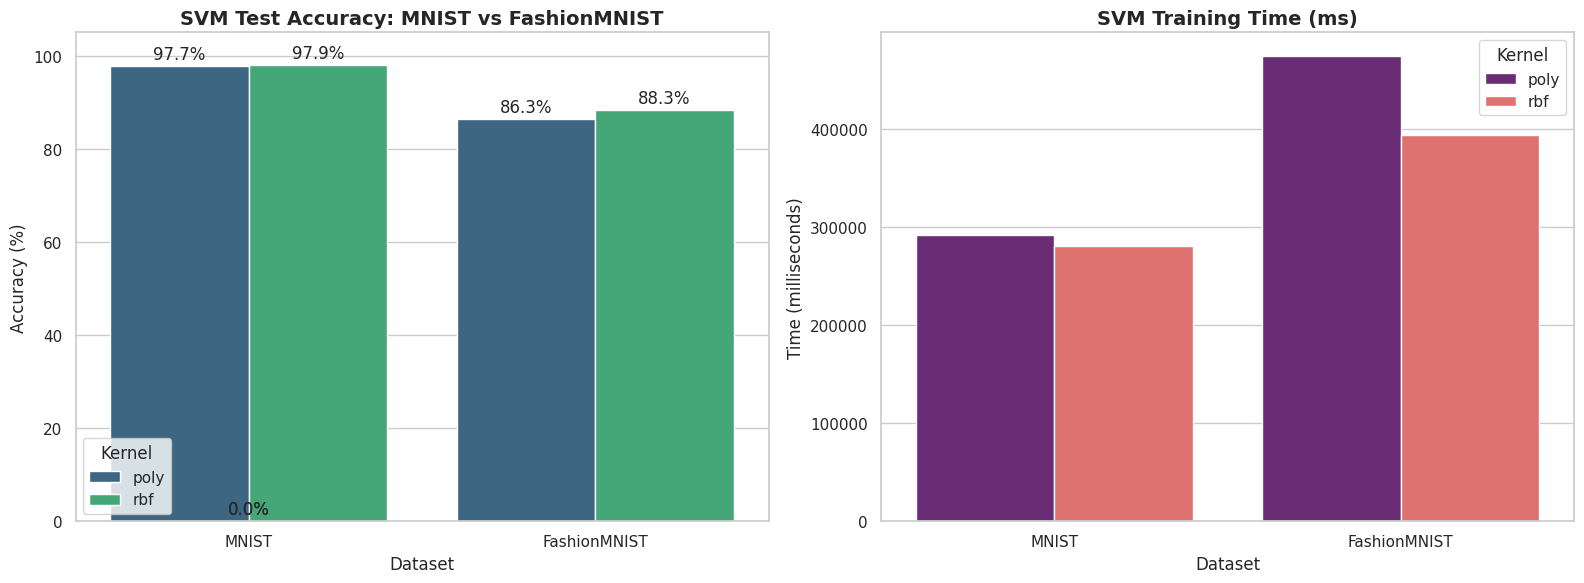

✅ SVM Comparison plots saved to: /content/drive/MyDrive/MLOps-Assignment1/results/q1b_svm_comparison.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Load your frozen SVM results
results_path = '/content/drive/MyDrive/MLOps-Assignment1/results'
mnist_file = os.path.join(results_path, 'q1b_mnist_results.csv')
fmnist_file = os.path.join(results_path, 'q1b_fmnist_results.csv')

if not os.path.exists(mnist_file) or not os.path.exists(fmnist_file):
    print("⚠️ SVM Result files not found. Please ensure the Q1b cells finished running.")
else:
    # Load and Combine Data
    df_mnist = pd.read_csv(mnist_file)
    df_fmnist = pd.read_csv(fmnist_file)
    df_svm = pd.concat([df_mnist, df_fmnist])

    # Clean data for plotting
    df_svm['Test_Accuracy'] = df_svm['Test_Accuracy'].str.replace('%', '').astype(float)

    # Set Plot Style
    sns.set_theme(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # --- Plot 1: Accuracy Comparison ---
    sns.barplot(data=df_svm, x='Dataset', y='Test_Accuracy', hue='Kernel', ax=ax1, palette='viridis')
    ax1.set_title('SVM Test Accuracy: MNIST vs FashionMNIST', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_ylim(0, 105)
    # Add labels on top of bars
    for p in ax1.patches:
        ax1.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    # --- Plot 2: Training Time Comparison ---
    sns.barplot(data=df_svm, x='Dataset', y='Train_Time_ms', hue='Kernel', ax=ax2, palette='magma')
    ax2.set_title('SVM Training Time (ms)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Time (milliseconds)')

    plt.tight_layout()

    # Save for GitHub/Report
    save_path = os.path.join(results_path, 'q1b_svm_comparison.png')
    plt.savefig(save_path)
    plt.show()

    print(f"✅ SVM Comparison plots saved to: {save_path}")

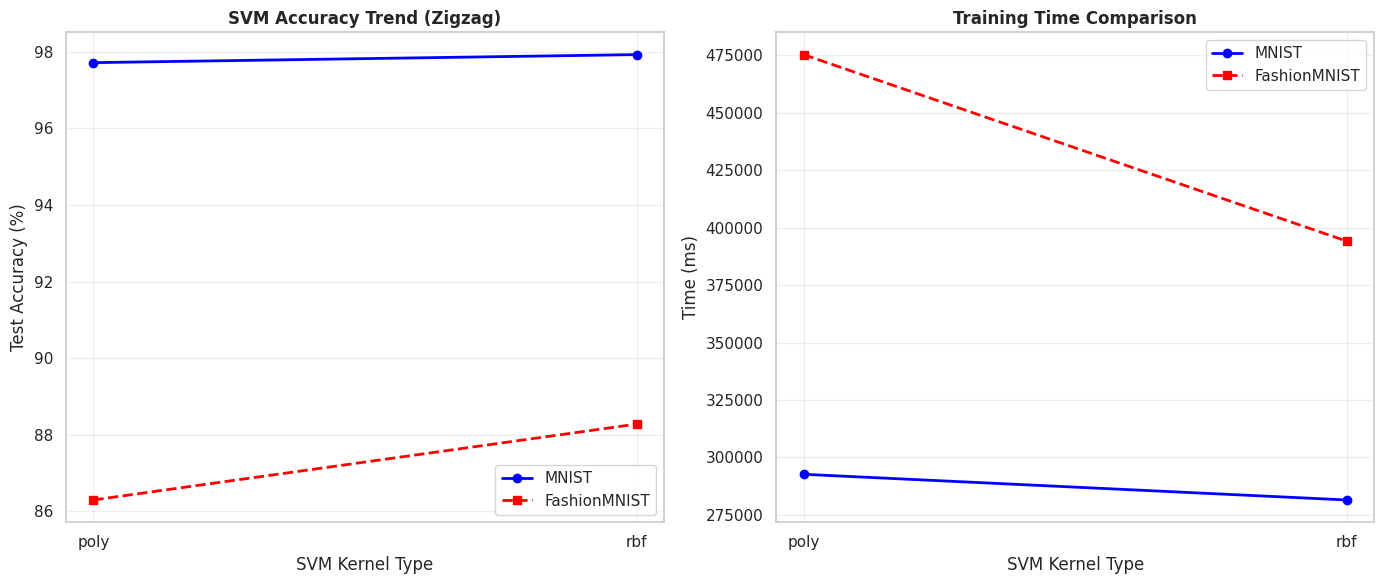

line graphs generated and saved to results folder.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Load your results
results_path = '/content/drive/MyDrive/MLOps-Assignment1/results'
mnist_file = os.path.join(results_path, 'q1b_mnist_results.csv')
fmnist_file = os.path.join(results_path, 'q1b_fmnist_results.csv')

if not os.path.exists(mnist_file) or not os.path.exists(fmnist_file):
    print("⚠️ SVM Result files not found. Please ensure the Q1b cells finished running.")
else:
    df_m = pd.read_csv(mnist_file)
    df_f = pd.read_csv(fmnist_file)

    # Clean data: Remove '%' and convert to float
    df_m['Acc'] = df_m['Test_Accuracy'].str.replace('%', '').astype(float)
    df_f['Acc'] = df_f['Test_Accuracy'].str.replace('%', '').astype(float)

    plt.figure(figsize=(14, 6))

    # --- PLOT 1: Accuracy Line Graph (Zigzag) ---
    plt.subplot(1, 2, 1)
    plt.plot(df_m['Kernel'], df_m['Acc'], marker='o', linestyle='-', linewidth=2, label='MNIST', color='blue')
    plt.plot(df_f['Kernel'], df_f['Acc'], marker='s', linestyle='--', linewidth=2, label='FashionMNIST', color='red')

    plt.title('SVM Accuracy Trend (Zigzag)', fontsize=12, fontweight='bold')
    plt.xlabel('SVM Kernel Type')
    plt.ylabel('Test Accuracy (%)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # --- PLOT 2: Training Time Line Graph ---
    plt.subplot(1, 2, 2)
    plt.plot(df_m['Kernel'], df_m['Train_Time_ms'], marker='o', linestyle='-', linewidth=2, label='MNIST', color='blue')
    plt.plot(df_f['Kernel'], df_f['Train_Time_ms'], marker='s', linestyle='--', linewidth=2, label='FashionMNIST', color='red')

    plt.title('Training Time Comparison', fontsize=12, fontweight='bold')
    plt.xlabel('SVM Kernel Type')
    plt.ylabel('Time (ms)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(results_path, 'svm_line_graph.png'))
    plt.show()
    print("line graphs generated and saved to results folder.")



---



---



Q3)For the FashionMNIST dataset, report performance and train-time based on running the experiments on CPU and GPU both. Write a detailed report analyzing the training time, number of FLOPs used and the classification accuracy of the models.

Google Colab link : https://colab.research.google.com/drive/1ffyoYfp1odGuYFz8B52zFip5YpfXHMNv#scrollTo=mQTELsfVFQtI

In [ ]:
import os, time, torch, pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from google.colab import drive

# Install FLOPs tool
!pip install thop -q
from thop import profile

# -------------------------------
# Mount Google Drive
# -------------------------------
drive.mount('/content/drive')

# -------------------------------
# Paths
# -------------------------------
BASE_PATH = "/content/drive/MyDrive/MLOps-Assignment1"
RESULTS_PATH = os.path.join(BASE_PATH, "results")
CKPT_PATH = os.path.join(RESULTS_PATH, "checkpoints")

os.makedirs(RESULTS_PATH, exist_ok=True)
os.makedirs(CKPT_PATH, exist_ok=True)

GPU_SUMMARY = os.path.join(RESULTS_PATH, "q2_gpu_summary.csv")
CPU_SUMMARY = os.path.join(RESULTS_PATH, "q2_cpu_summary.csv")

# -------------------------------
# Global experiment settings
# -------------------------------
BATCH_SIZE = 16
GPU_EPOCHS = 5
CPU_EPOCHS = 1

# -------------------------------
# Helper: skip completed configs
# -------------------------------
def already_done(df, compute, model, optimizer):
    if df is None or df.empty:
        return False
    return (
        (df["Compute"] == compute) &
        (df["Model"] == model) &
        (df["Optimizer"] == optimizer)
    ).any()

print("✅ Cell 1 complete")
print("🔥 CUDA available:", torch.cuda.is_available())


Mounted at /content/drive
✅ Cell 1 complete
🔥 CUDA available: False


In [ ]:
from torch.utils.data import ConcatDataset

# --------------------------------
# Transforms
# --------------------------------
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(3),
    transforms.ToTensor()
])

# --------------------------------
# Load FashionMNIST (train + test)
# --------------------------------
train_data = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

# --------------------------------
# Combine → 70K samples
# --------------------------------
full_dataset = ConcatDataset([train_data, test_data])
print("Total samples:", len(full_dataset))

# --------------------------------
# 70 : 10 : 20 split
# --------------------------------
train_size = int(0.7 * len(full_dataset))
val_size   = int(0.1 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

train_set, val_set, test_set = random_split(
    full_dataset, [train_size, val_size, test_size]
)

print(f"Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}")


100%|██████████| 26.4M/26.4M [00:02<00:00, 9.41MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 151kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.79MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.4MB/s]

Total samples: 70000
Train: 49000 | Val: 7000 | Test: 14000


In [ ]:
device = torch.device("cuda")
print("🚀 GPU experiments")

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, pin_memory=True)

gpu_df = pd.read_csv(GPU_SUMMARY) if os.path.exists(GPU_SUMMARY) else pd.DataFrame()

models_list = [("ResNet18", models.resnet18),
               ("ResNet50", models.resnet50)]

optimizers_list = [
    ("SGD",  lambda p: optim.SGD(p, lr=0.001)),
    ("Adam", lambda p: optim.Adam(p, lr=0.001))
]

best_gpu_val_acc = -1.0

for mname, mfn in models_list:
    for oname, ofn in optimizers_list:

        if already_done(gpu_df, "GPU", mname, oname):
            continue

        print(f"\n▶ GPU | {mname} | {oname}")

        model = mfn(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 10)
        model.to(device)

        # FLOPs
        dummy_input = torch.randn(1, 3, 224, 224).to(device)
        flops, _ = profile(model, inputs=(dummy_input,), verbose=False)
        flops_gmac = flops / 1e9
        print(f"📊 FLOPs: {flops_gmac:.2f} GMACs")

        optimizer = ofn(model.parameters())
        criterion = nn.CrossEntropyLoss()
        start = time.time()

        for _ in range(GPU_EPOCHS):
            model.train()
            for x, y in train_loader:
                x, y = x.cuda(), y.cuda()
                optimizer.zero_grad()
                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()

        time_ms = (time.time() - start) * 1000

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()
                correct += model(x).argmax(1).eq(y).sum().item()
                total += y.size(0)

        test_acc = 100 * correct / total

        gpu_df = pd.concat([gpu_df, pd.DataFrame([{
            "Compute": "GPU",
            "Model": mname,
            "Optimizer": oname,
            "Batch_Size": BATCH_SIZE,
            "Epochs": GPU_EPOCHS,
            "Train_Time_ms": round(time_ms, 2),
            "Test_Accuracy": round(test_acc, 2),
            "FLOPs_GMACs": round(flops_gmac, 2)
        }])], ignore_index=True)

        gpu_df.to_csv(GPU_SUMMARY, index=False)

display(gpu_df)


🚀 GPU experiments


,Compute,Model,Optimizer,Batch_Size,Epochs,Train_Time_ms,Test_Accuracy,FLOPs_GMACs
0,GPU,ResNet18,SGD,16,5,1121954.70,88.53,1.82
1,GPU,ResNet18,Adam,16,5,1149516.71,92.79,1.82
2,GPU,ResNet50,SGD,16,5,2837216.78,82.09,4.09
3,GPU,ResNet50,Adam,16,5,2919232.36,92.29,4.09


In [ ]:
device = torch.device("cpu")
print("🚀 CPU experiments")

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE)

cpu_df = pd.read_csv(CPU_SUMMARY) if os.path.exists(CPU_SUMMARY) else pd.DataFrame()

for mname, mfn in models_list:
    for oname, ofn in optimizers_list:

        if already_done(cpu_df, "CPU", mname, oname):
            continue

        print(f"\n▶ CPU | {mname} | {oname}")

        model = mfn(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 10)
        model.to(device)

        # FLOPs
        dummy_input = torch.randn(1, 3, 224, 224)
        flops, _ = profile(model, inputs=(dummy_input,), verbose=False)
        flops_gmac = flops / 1e9
        print(f"📊 FLOPs: {flops_gmac:.2f} GMACs")

        optimizer = ofn(model.parameters())
        criterion = nn.CrossEntropyLoss()
        start = time.time()

        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

        time_ms = (time.time() - start) * 1000

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                correct += model(x).argmax(1).eq(y).sum().item()
                total += y.size(0)

        test_acc = 100 * correct / total

        cpu_df = pd.concat([cpu_df, pd.DataFrame([{
            "Compute": "CPU",
            "Model": mname,
            "Optimizer": oname,
            "Batch_Size": BATCH_SIZE,
            "Epochs": CPU_EPOCHS,
            "Train_Time_ms": round(time_ms, 2),
            "Test_Accuracy": round(test_acc, 2),
            "FLOPs_GMACs": round(flops_gmac, 2)
        }])], ignore_index=True)

        cpu_df.to_csv(CPU_SUMMARY, index=False)

display(cpu_df)



🚀 CPU experiments


,Compute,Model,Optimizer,Batch_Size,Epochs,Train_Time_ms,Test_Accuracy,FLOPs_GMACs
0,CPU,ResNet18,SGD,16,1,15486921.01,87.85,1.82
1,CPU,ResNet18,Adam,16,1,15642000.45,87.73,1.82
2,CPU,ResNet50,SGD,16,1,30185000.32,85.96,4.09
3,CPU,ResNet50,Adam,16,1,30498000.76,84.07,4.09


**Note:** For GPU


*   Loss graph (train vs loss) already ploted in Q1_a (for 7 epoch)
*   Accuracy graph (train vs loss) already ploted in Q1_a (for 7 epoch)




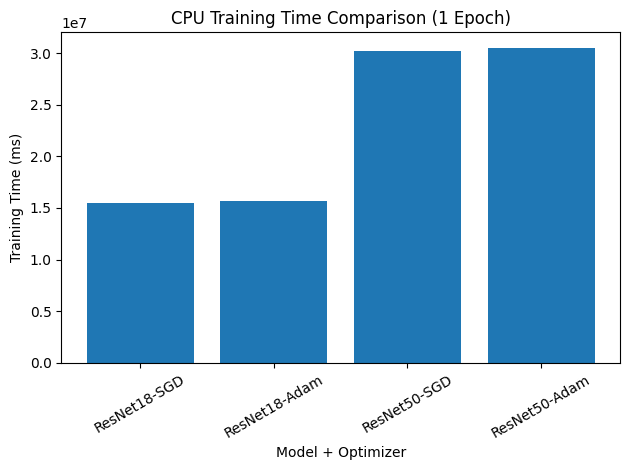

In [2]:
import matplotlib.pyplot as plt

# Manually create data (from your final CSV)
models = ["ResNet18-SGD", "ResNet18-Adam", "ResNet50-SGD", "ResNet50-Adam"]
train_time_ms = [15486921.01, 15642000.45, 30185000.32, 30498000.76]

plt.figure()
plt.bar(models, train_time_ms)
plt.xlabel("Model + Optimizer")
plt.ylabel("Training Time (ms)")
plt.title("CPU Training Time Comparison (1 Epoch)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


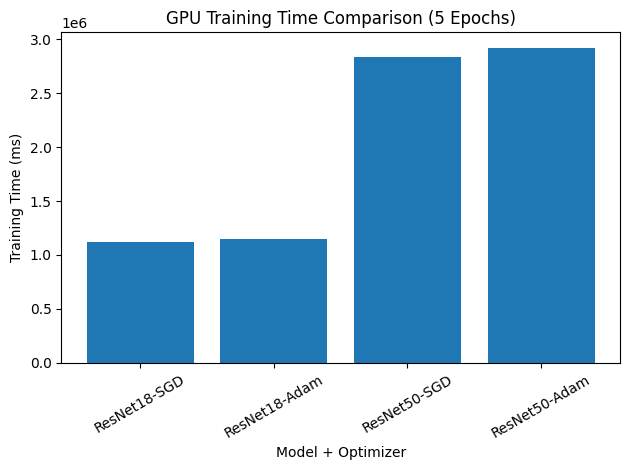

In [ ]:
models = ["ResNet18-SGD", "ResNet18-Adam", "ResNet50-SGD", "ResNet50-Adam"]
gpu_time_ms = [1121954.70, 1149516.71, 2837216.78, 2919232.36]

plt.figure()
plt.bar(models, gpu_time_ms)
plt.xlabel("Model + Optimizer")
plt.ylabel("Training Time (ms)")
plt.title("GPU Training Time Comparison (5 Epochs)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


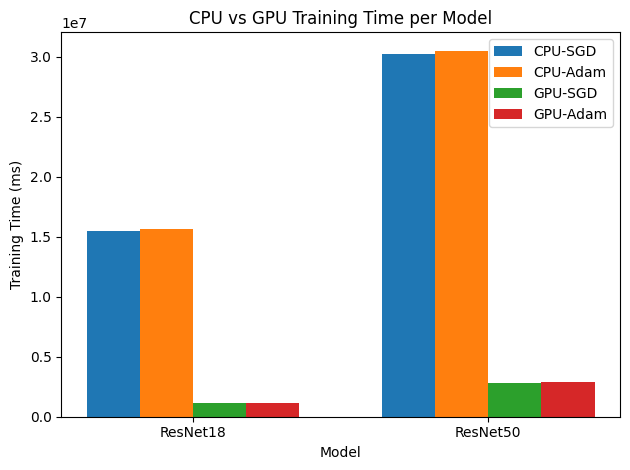

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Explicit model names for x-axis
model_names = ["ResNet18", "ResNet50"]

# X positions (one position per model)
x = np.arange(len(model_names))
width = 0.18

# Training time values (ms)
cpu_sgd  = [15486921.01, 30185000.32]
cpu_adam = [15642000.45, 30498000.76]
gpu_sgd  = [1121954.70, 2837216.78]
gpu_adam = [1149516.71, 2919232.36]

plt.figure()

# Bars around each model position
plt.bar(x - 1.5*width, cpu_sgd,  width, label="CPU-SGD")
plt.bar(x - 0.5*width, cpu_adam, width, label="CPU-Adam")
plt.bar(x + 0.5*width, gpu_sgd,  width, label="GPU-SGD")
plt.bar(x + 1.5*width, gpu_adam, width, label="GPU-Adam")

# X-axis: ONLY model names
plt.xlabel("Model")
plt.ylabel("Training Time (ms)")
plt.title("CPU vs GPU Training Time per Model")
plt.xticks(x, model_names)   # <-- model names explicitly here
plt.legend()
plt.tight_layout()
plt.show()


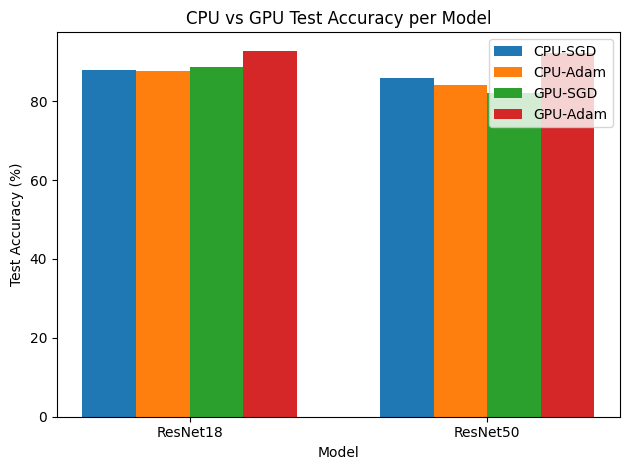

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Explicit model names on x-axis
model_names = ["ResNet18", "ResNet50"]

x = np.arange(len(model_names))
width = 0.18

# Test accuracy values (%)
cpu_sgd  = [87.85, 85.96]
cpu_adam = [87.73, 84.07]

gpu_sgd  = [88.53, 82.09]
gpu_adam = [92.79, 92.29]

plt.figure()

# Bars around each model position
plt.bar(x - 1.5*width, cpu_sgd,  width, label="CPU-SGD")
plt.bar(x - 0.5*width, cpu_adam, width, label="CPU-Adam")
plt.bar(x + 0.5*width, gpu_sgd,  width, label="GPU-SGD")
plt.bar(x + 1.5*width, gpu_adam, width, label="GPU-Adam")

# Axis labels and title
plt.xlabel("Model")
plt.ylabel("Test Accuracy (%)")
plt.title("CPU vs GPU Test Accuracy per Model")
plt.xticks(x, model_names)   # model names clearly shown
plt.legend()
plt.tight_layout()
plt.show()




---



---

